# TextCNN情感分析实验

本实验主要基于卷积神经网络对电影评论信息进行情感分析，判断其情感倾向。


## 实验目的

- 理解文本分类的基本流程
- 理解CNN网络在文本任务中的用法
- 掌握MindSpore搭建文本分类模型的方法


## TextCNN原理介绍

CNN 卷积神经网络通常应用于 CV 领域，主要用于解决计算机视觉方向问题的模型，但是在2014年，Yoon Kim发表了论文 [Convolutional Neural Networks for Sentence Classification](https://arxiv.org/pdf/1408.5882.pdf) 针对 CNN 模型的输入层做了一些变形，提出了文本分类模型 TextCNN 。该模型体系结构是Collobert等人在论文[Natural Language Processing (almost) from Scratch](https://arxiv.org/pdf/1103.0398v1.pdf)中提出的CNN体系结构的一个轻微变体。与传统图像的CNN网络相比，TextCNN 在网络结构上没有任何变化(甚至更加简单)。

模型的结构如下图（图片来源于原论文）所示：

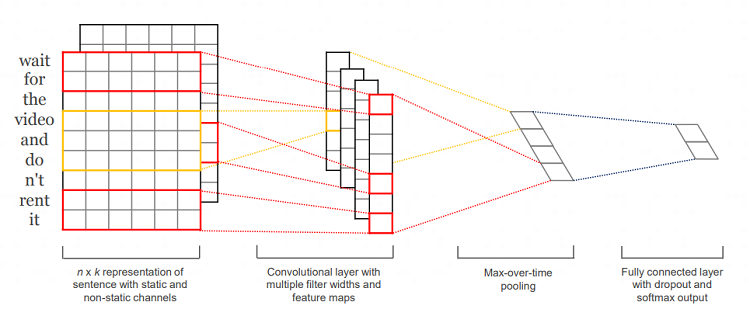

从图中可以看出，第一部分是对文本进行一个向量表示，然后接大小不同的卷积层，并将得到的特征向量拼接起来，后面再接 `Max Pooling` 层，最后连接加了 `Dropout` 的全连接层再外接外接 `Softmax` 来 n 分类的输出。具体模型结构细节见下文代码。


## 实验环境

ModelArts Notebook环境，目前仅支持GPU/Ascend，具体参考实验正文。


## 数据处理

本案例使用的是一个关于电影评论的数据集，首次被使用是由 Bo Pang 和 Lillian Lee 在2005年。该数据集的评论的数据来源于烂番茄网站，包含两种评论，一种是积极的一种消极的，两种评论各包含5331条，分两个文件，文件的每一行代表一条数据。数据下载的链接见下文代码。

数据文件的结构：

```text
rt-polaritydata.README.1.0.txt
rt-polaritydata/
    ├── rt-polarity.neg
    └── rt-polarity.pos
```


### 数据集下载

使用 `download` 接口下载数据集，并将下载后的数据集自动解压到当前目录下。数据下载之前需要使用 `pip install download` 安装 `download` 包。


In [2]:
from download import download

url = "https://www.cs.cornell.edu/people/pabo/movie-review-data/rt-polaritydata.tar.gz"

download(url, "./", kind="tar.gz", replace=True)


file_sizes: 100%|█████████████████████████████| 488k/488k [00:04<00:00, 110kB/s]
Extracting tar.gz file...
Successfully downloaded / unzipped to ./


'./'

### 预处理

先按行读取数据集，再使用 `rstrip` 方法去除后缀字符，然后通过 `translate` 方法去除句子中的标点符号，再统一变为小写，再按照空格分词。这里选单词作为最小单元，按照每个单词出现的先后顺序进行编码，然后用 0 将每条数据填充到最长数据的长度。本案例是将整个数据集按 7:3 的比例进行拆分，70% 数据用于训练，剩下 30% 用于模型的验证。具体情况见如下代码：


In [2]:
import os
import string
import random
import mindspore.dataset as ds

class PolarityData:
    def __init__(self, path):
        self.feelMap = {'neg': 0, 'pos': 1}
        self.path = path
        self.vec_set = []
        self.max_len = 0
        self.vocab = dict()

        self.data = self._load()

    def _load(self):
        file = os.listdir(self.path)
        a = []
        for e in file:
            file_name = os.path.join(self.path, e)
            with open(file_name, 'r', encoding='Windows-1252') as sentences_set:
                for sentences in sentences_set.readlines():
                    sentences = sentences.rstrip().translate(str.maketrans('', '', string.punctuation)).lower().split()
                    if 'pos' in file_name:
                        a.append([sentences, self.feelMap['pos']])
                    else:
                        a.append([sentences, self.feelMap['neg']])

                    self.max_len = self.max_len if self.max_len >= len(sentences) else len(sentences)

        for sentences1 in a:
            vectors = [0] * self.max_len
            for index, word in enumerate(sentences1[0]):
                if index >= self.max_len:
                    break
                if word not in self.vocab.keys():
                    self.vocab[word] = len(self.vocab) + 1
                    vectors[index] = len(self.vocab)
                else:
                    vectors[index] = self.vocab[word]

            self.vec_set.append([vectors, sentences1[1]])

        random.shuffle(self.vec_set)
        return self.vec_set

    def get_len(self):
        return self.vocab, len(self.vocab), self.max_len

    def __getitem__(self, item):
        return (np.array(self.data[item][0], dtype=np.int32),
                np.array(self.data[item][1], dtype=np.int32))

    def __len__(self):
        return len(self.vec_set)

data_path = './rt-polaritydata/'
batch_size = 16  # 批量大小
epoch_size = 8   

dataset = ds.GeneratorDataset(source=PolarityData(path=data_path),
    column_names=["data", "label"],
    shuffle=False)

# 分训练和验证数据集
dataset_train, dataset_valid = dataset.split([0.7, 0.3])
valid_size = dataset_valid.get_dataset_size()

dataset_train = dataset_train.batch(batch_size=batch_size, drop_remainder=True)
dataset_valid = dataset_valid .batch(batch_size=1, drop_remainder=True)
step_num = dataset_train.get_dataset_size()
vocab, vocab_size, word_len = PolarityData(path=data_path).get_len()


### 数据展示

In [3]:
# 数据预览
with open("./rt-polaritydata/rt-polarity.pos", 'r', encoding='Windows-1252') as f:
    for i, sentences in enumerate(f.readlines()):
        if i == 10:
            print('原数据：\n')
            print(sentences, '\n')
            sentences = sentences.rstrip().translate(str.maketrans('', '', string.punctuation)).lower().split()
            print('预处理之后：\n')
            print(sentences, '\n')
            vectors = [0] * word_len
            for index, word in enumerate(sentences):
                if word in vocab.keys():
                    vectors[index] = vocab[word]
                else:
                    continue
            print('向量化之后：\n')
            print(vectors)
            break
        else:
            continue

原数据：

this is a film well worth seeing , talking and singing heads and all . 
 

预处理之后：

['this', 'is', 'a', 'film', 'well', 'worth', 'seeing', 'talking', 'and', 'singing', 'heads', 'and', 'all'] 

向量化之后：

[142, 3, 16, 83, 143, 144, 145, 146, 11, 147, 148, 11, 91, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


## 模型构建

模型主要结构有一下四个部分：

1. 词嵌入层，即Embedding层。这一层原理通过某种矩阵乘法来实现矩阵数据的降维，将原来有很多填充0的稀疏矩阵变的更密集一些。本文是将单条长度为51的数据降到了40。
2. 基本的卷积层。使用2、3、4等不同的卷积核对词嵌入转化后的句子进行卷积操作，生成不同的特征数据；
3. 池化层。对多通道卷积层中输出的每一个通道特征作全局最大池化。
4. 全连接层。将池化后的结果如入全连接网络，输出分类个数，得到最终分类结果。


In [4]:
import numpy as np
from mindspore import nn, ops, Tensor

class TextCNN(nn.Cell):
    def __init__(self, vocab_len, word_len, num_classes, vec_length):
        super(TextCNN, self).__init__()
        self.vec_length = vec_length
        self.word_len = word_len
        self.num_classes = num_classes
        self.embedding = nn.Embedding(vocab_len, self.vec_length, embedding_table='normal')

        self.layer1 = self._make_layer(kernel_height=3)
        self.layer2 = self._make_layer(kernel_height=4)
        self.layer3 = self._make_layer(kernel_height=5)

        self.fc = nn.Dense(96 * 3, self.num_classes)
        self.drop = nn.Dropout(keep_prob=0.5)
        self.reducemean = ops.ReduceMax(keep_dims=False)

    def _make_conv_layer(self, kernel_size):
        weight_shape = (96, 1, *kernel_size)
        weight = Tensor(np.random.randn(*weight_shape).astype(np.float32) * 0.01)
        return nn.Conv2d(in_channels=1, out_channels=96, kernel_size=kernel_size, padding=1,
                         pad_mode="pad", weight_init=weight, has_bias=True)

    def _make_layer(self, kernel_height):
        return nn.SequentialCell([self._make_conv_layer((kernel_height, self.vec_length)),
                                  nn.ReLU(),
                                  nn.MaxPool2d(kernel_size=(self.word_len - kernel_height + 1, 1))])

    def construct(self, x):
        x = ops.expand_dims(x, 1)
        x = self.embedding(x)
        x1 = self.layer1(x)
        x2 = self.layer2(x)
        x3 = self.layer3(x)

        x1 = self.reducemean(x1, (2, 3))
        x2 = self.reducemean(x2, (2, 3))
        x3 = self.reducemean(x3, (2, 3))

        x = ops.concat((x1, x2, x3), 1)
        x = self.drop(x)
        x = self.fc(x)
        return x

# 模型实例化
vec_length = 40
num_classes = 2
net = TextCNN(vocab_len=vocab_size, word_len=word_len,
              num_classes=num_classes, vec_length=vec_length)


## 损失函数和优化器

完成模型主体构建后，然后选择损失函数和优化器。针对本案例使用的文本数据的特性，即一个Positive或Negative的二分类问题，我们选择带 `softmax` 的交叉熵损失函数 `nn.SoftmaxCrossEntropyWithLogits`。


In [5]:
import math
# 学习率
learning_rate = []
num = math.floor(epoch_size / 5)
warm_up = [1e-3 / num * (i + 1) for _ in range(step_num)
           for i in range(num)]
shrink = [1e-3 / (16 * (i + 1)) for _ in range(step_num)
          for i in range(math.floor(epoch_size * 3 / 5))]
normal_run = [1e-3 for _ in range(step_num)
              for i in range(epoch_size - num - math.floor(epoch_size * 2 / 5))]
learning_rate = learning_rate + warm_up + normal_run + shrink

# 优化器
opt = nn.Adam(net.trainable_params(), learning_rate=learning_rate, weight_decay=3e-5)

# 损失函数
loss = nn.SoftmaxCrossEntropyWithLogits(sparse=True, reduction='mean')


## 训练过程

训练过程主要是先前向计算损失，然后根据损失值计算梯度，再根据梯度更新模型参数，最后打印损失保存权重文件。


In [6]:
import time
import mindspore as ms
from mindspore import save_checkpoint

from mindspore import context
context.set_context(mode=context.PYNATIVE_MODE, device_target='GPU', device_id=0)

# 前向计算
def forward(data):
    result = net(data['data'])
    loss_a = loss(result, data['label'])
    return loss_a

grad_fn = ms.value_and_grad(forward, None, net.trainable_params())

# 梯度计算
def train_step(data):
    loss_n, grads = grad_fn(data)
    opt(grads)
    return loss_n

print("Start training!")
for i in range(epoch_size):
    start = time.time()
    for iter, data in enumerate(dataset_train.create_dict_iterator()):
        start1 = time.time()
        loss_1 = train_step(data)
        if iter % 20 == 0:
            print(f"Epoch:[{int(i+1):>3d}/{int(epoch_size):>3d}], "
                  f"step:[{int(iter):>4d}/{int(step_num):>4d}], "
                  f"loss:{loss_1.asnumpy():>4f} , "
                  f"time:{(time.time() - start1):>3f}s, "
                  f"lr:{learning_rate[i*step_num + iter]:>6f}")

    end = time.time()
    print("Time of epoch {} is {:.2f}s".format(i + 1, end - start))

    # 根据epoch保存模型权重文件
    if i % 1 == 0:
        save_checkpoint(net, f"./textcnn_{i+1}.ckpt")
print("End of training!")



Start training!
Epoch:[  1/  8], step:[   0/ 466], loss:0.693124 , time:5.039201s, lr:0.001000
Epoch:[  1/  8], step:[  20/ 466], loss:0.694083 , time:0.098376s, lr:0.001000
Epoch:[  1/  8], step:[  40/ 466], loss:0.699517 , time:0.098735s, lr:0.001000
Epoch:[  1/  8], step:[  60/ 466], loss:0.698310 , time:0.030272s, lr:0.001000
Epoch:[  1/  8], step:[  80/ 466], loss:0.695693 , time:0.030581s, lr:0.001000
Epoch:[  1/  8], step:[ 100/ 466], loss:0.687557 , time:0.098801s, lr:0.001000
Epoch:[  1/  8], step:[ 120/ 466], loss:0.693420 , time:0.029501s, lr:0.001000
Epoch:[  1/  8], step:[ 140/ 466], loss:0.693596 , time:0.030466s, lr:0.001000
Epoch:[  1/  8], step:[ 160/ 466], loss:0.665807 , time:0.101108s, lr:0.001000
Epoch:[  1/  8], step:[ 180/ 466], loss:0.666850 , time:0.030652s, lr:0.001000
Epoch:[  1/  8], step:[ 200/ 466], loss:0.636276 , time:0.080867s, lr:0.001000
Epoch:[  1/  8], step:[ 220/ 466], loss:0.746906 , time:0.098944s, lr:0.001000
Epoch:[  1/  8], step:[ 240/ 466], l

Epoch:[  5/  8], step:[ 140/ 466], loss:0.021040 , time:0.034734s, lr:0.001000
Epoch:[  5/  8], step:[ 160/ 466], loss:0.043339 , time:0.033906s, lr:0.001000
Epoch:[  5/  8], step:[ 180/ 466], loss:0.103608 , time:0.033985s, lr:0.001000
Epoch:[  5/  8], step:[ 200/ 466], loss:0.337978 , time:0.034595s, lr:0.001000
Epoch:[  5/  8], step:[ 220/ 466], loss:0.239948 , time:0.048528s, lr:0.001000
Epoch:[  5/  8], step:[ 240/ 466], loss:0.165465 , time:0.034614s, lr:0.001000
Epoch:[  5/  8], step:[ 260/ 466], loss:0.029339 , time:0.058889s, lr:0.001000
Epoch:[  5/  8], step:[ 280/ 466], loss:0.294467 , time:0.034573s, lr:0.001000
Epoch:[  5/  8], step:[ 300/ 466], loss:0.234154 , time:0.062460s, lr:0.001000
Epoch:[  5/  8], step:[ 320/ 466], loss:0.071159 , time:0.034548s, lr:0.001000
Epoch:[  5/  8], step:[ 340/ 466], loss:0.096310 , time:0.034522s, lr:0.001000
Epoch:[  5/  8], step:[ 360/ 466], loss:0.047150 , time:0.034688s, lr:0.001000
Epoch:[  5/  8], step:[ 380/ 466], loss:0.108065 , t

## 模型验证

模型验证主要是模型加载训练好的权重文件，然后输入数据进行前向过程，然后得出结果。


In [7]:
import time
import tqdm
import mindspore as ms
from mindspore import save_checkpoint

test_ckpt = './textcnn_8.ckpt'
parameter = ms.load_checkpoint(test_ckpt)
ms.load_param_into_net(net, parameter)
ok_num = 0

total = dataset_valid.get_dataset_size()
with tqdm.tqdm(total=total) as t:
    for step, data in enumerate(dataset_valid.create_dict_iterator()):
        output = net(data['data'])
        if np.argmax(np.array(output[0])) == data['label']:
            ok_num = ok_num + 1
        t.set_postfix(acc=ok_num/valid_size)
        t.update(1)


100%|██████████| 3199/3199 [00:30<00:00, 105.41it/s, acc=0.987]


## 模型预测

最后我们设计一个预测函数，实现输入一句评价，获得评价的情感分类。具体包含以下步骤:

1. 将输入句子进行分词等前文讲过的前处理操作；
2. 使用词表获取对应的对应单词的数组表示（注意：输入的评价的单词必须存在于本案例使用的数据集里）；
3. 送入模型获得预测结果；
4. 打印输出预测结果。


In [13]:
def predict(sentences):
    sentences = sentences.rstrip().translate(str.maketrans('', '', string.punctuation)).lower().split()
    vectors = [0] * word_len
    for index, word in enumerate(sentences):
        if word in vocab.keys():
            vectors[index] = vocab[word]
        else:
            continue
    output = net(Tensor([vectors]))
    if np.argmax(np.array(output[0])) == 1:
        print('Positive!')
    else:
        print('Negative')


In [15]:
predict('This is a film well worth seeing .')

Positive!


In [16]:
predict('On its own , it is not very interesting .')

Negative
